In [ ]:
cd ../input/kidney-cancer/data

/kaggle/input/kidney-cancer/data


In [ ]:
!pip install pkbar

In [ ]:
import torch
import torchvision as tv 
from torchvision import datasets, transforms
import torch.nn as nn 
from torch.nn import functional as F
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt 
import os
from tqdm import tqdm
import pkbar
train_dir = './Training_images'
test_dir = './Test_images'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 32
classes = 5
input_shape = (3, 224, 224)
epochs = 50
train_transforms = transforms.Compose(
    [
     transforms.RandomRotation(30),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)
trainData = datasets.ImageFolder(train_dir, transform = train_transforms)
testData = datasets.ImageFolder(test_dir, transform = test_transforms)

l_data = len(trainData)

class_dict=trainData.class_to_idx
class_labels = class_dict.values()

train_split = int(0.8*l_data)
val_split = l_data - train_split

trainData, valData = torch.utils.data.random_split(trainData, [train_split, val_split])

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valData, batch_size = batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size = batch_size, shuffle = True)

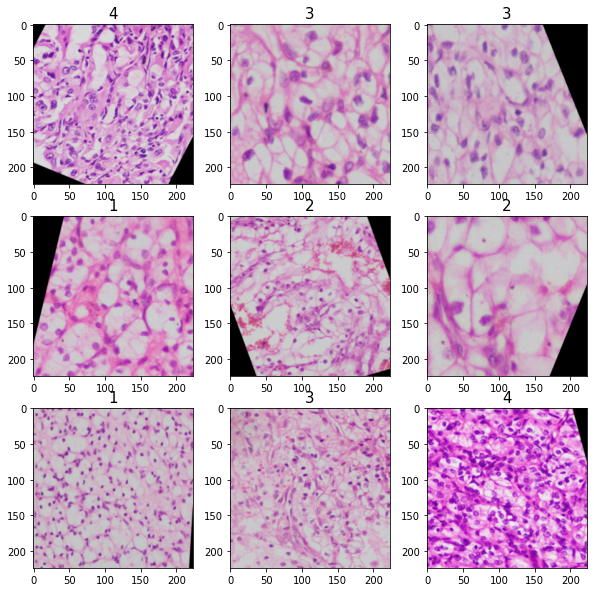

In [ ]:
def plot_random_sample(loader):
    iterate = iter(loader)
    iternext = next(iterate)
    img, lab = iternext
    # print(len(img))
    fig, ax = plt.subplots(3, 3, figsize = (10, 10), )
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(img[j + 3*i].permute(2, 1, 0))
            ax[i][j].set_title(lab[j + 3*i].item(), fontsize = 15)
    
    plt.show()
plot_random_sample(trainLoader)

In [ ]:
def accuracy(prediction, label):
    n_correct = 0
    n_samples = 0
    _, preds = prediction.max(1)
    n_correct += (preds == label).sum()
    n_samples = preds.size(0)
    return n_correct/n_samples

In [ ]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
class Res_Block(nn.Module):
    exp = 4

    def __init__(self, in_planes, out_planes, dims_change = None, stride = 1):
        super(Res_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, stride = 1, kernel_size = 1, padding = 0)
        self.bnorm1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, stride = stride, kernel_size = 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.exp, stride = 1, kernel_size = 1, padding = 0)
        self.bnorm3 = nn.BatchNorm2d(out_planes*self.exp)
        self.relu = nn.ReLU()
        self.dims_change = dims_change 

    def forward(self, x):
        residue = x
        x = self.conv1(x)
        x = self.relu(self.bnorm1(x))
        x = self.conv2(x)
        x = self.relu(self.bnorm2(x))
        x = self.conv3(x)
        x = self.bnorm3(x)

        if self.dims_change is not None:
            residue = self.dims_change(residue)

        x += residue
        return self.relu(x)
            
class ResNet50(nn.Module):
    def __init__(self, Res_Block, layers, channels, classes):
        super(ResNet50, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(channels, 64, stride = 2, kernel_size = 7, padding = 3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.maxPool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.l1 = self._convBlock(Res_Block, layers[0], out_planes = 64, stride = 1)
        self.l2 = self._convBlock(Res_Block, layers[1], out_planes = 128, stride = 2)
        self.l3 = self._convBlock(Res_Block, layers[2], out_planes = 256, stride = 2)
        self.l4 = self._convBlock(Res_Block, layers[3], out_planes = 512, stride = 2)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.dense = nn.Linear(512*4, classes)
        self.relu = nn.ReLU()

    def _convBlock(self, Res_Block, n_blocks, out_planes, stride):
        dims_change = None
        Layers = []
        if stride != 1 or self.in_planes != out_planes*4:
            dims_change = nn.Sequential(
                 nn.Conv2d(self.in_planes, out_planes*4, kernel_size = 1, stride = stride),
                 nn.BatchNorm2d(out_planes*4)
            )

        Layers.append(Res_Block(self.in_planes, out_planes, dims_change, stride))
        self.in_planes = out_planes * 4 
        for i in range(n_blocks - 1):
            Layers.append(Res_Block(self.in_planes, out_planes))

        return nn.Sequential(*Layers)

    def forward(self, x):
        x = nn.Sequential(
            self.conv1,
            self.bnorm1,
            self.relu,
            self.maxPool,
            self.l1, self.l2, self.l3, self.l4, 
            self.avgPool
        )(x)

        x = x.reshape(x.shape[0], -1)
        x = self.dense(x)
        return x

In [ ]:
model = ResNet50()
model[-1] = Linear(1000, 5)
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
print('Finished Training')

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 79%


In [ ]:
torch.save(model, './kidney-diagnosis.pt')